In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization, Dropout
from keras.optimizers import Adam, Adagrad
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

def create_dataset(dataset, y, look_back=4):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back:i+1, :]
        X.append(a)
        Y.append(y[i])
    return np.array(X), np.array(Y)

In [2]:
# Loading the data and preprocessing

excel_path = 'S&P 500 Index Dataset.xlsx'
snp500 = pd.read_excel(excel_path, sheet_name=1, header=0, index_col=0, parse_dates=False)

# keep the last 100 observations for testing
snp500_train = snp500.iloc[:-100]
snp500_test = snp500.iloc[-100:]

snp500_train['Direction'] = (snp500_train['Close'].shift(-5)>snp500_train['Close']).astype(int)
snp500_train = snp500_train.dropna()
snp500_test['Direction'] = (snp500_test['Close'].shift(-5)>snp500_test['Close']).astype(int)
snp500_test = snp500_test.dropna()

# input
X = snp500_train.drop(columns=['Direction'])
# output
Y = snp500_train['Direction']

# # resample
# smote = SMOTE(random_state=1)
# X, Y = smote.fit_resample(X, Y)
Y.value_counts()

/var/folders/yb/gzz3qfxx7sn6c9801nm9qp9h0000gn/T/ipykernel_5106/2772753664.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snp500_train['Direction'] = (snp500_train['Close'].shift(-5)>snp500_train['Close']).astype(int)
/var/folders/yb/gzz3qfxx7sn6c9801nm9qp9h0000gn/T/ipykernel_5106/2772753664.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snp500_test['Direction'] = (snp500_test['Close'].shift(-5)>snp500_test['Close']).astype(int)


Direction
1    5145
0    3748
Name: count, dtype: int64

In [3]:
# PCA with d = 32
d = 32
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(X)
pca = PCA(n_components=d, random_state=1)
df_pca = pca.fit_transform(df_scaled)

# look back to X=t-4, t-3, t-2, t-1, t and Y=t['Direction']
look_back = 9
X, Y = create_dataset(df_pca, snp500_train['Direction'].values, look_back)

# splitting the train and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

# X_train = np.reshape(X_train, (X_train.shape[0], look_back, X_train.shape[1]))
# X_test = np.reshape(X_test, (X_test.shape[0], look_back, X_test.shape[1]))

In [4]:
model = Sequential()
# first layer
model.add(LSTM(100,return_sequences=True, input_shape=(look_back+1, d)))
model.add(Dropout(0.2))
model.add(BatchNormalization()) 
# second layer
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization()) 
# third layer
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization()) 
# forth layer
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization()) 
# fifth layer
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(BatchNormalization()) 
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Epoch 1/1000
223/223 [==============================] - 9s 25ms/step - loss: 0.7436 - accuracy: 0.5478 - val_loss: 0.6908 - val_accuracy: 0.5689
Epoch 2/1000
223/223 [==============================] - 5s 23ms/step - loss: 0.7189 - accuracy: 0.5469 - val_loss: 0.6946 - val_accuracy: 0.5627
Epoch 3/1000
223/223 [==============================] - 5s 23ms/step - loss: 0.7051 - accuracy: 0.5488 - val_loss: 0.6913 - val_accuracy: 0.5627
Epoch 4/1000
223/223 [==============================] - 5s 23ms/step - loss: 0.7009 - accuracy: 0.5540 - val_loss: 0.6836 - val_accuracy: 0.5779
Epoch 5/1000
223/223 [==============================] - 5s 23ms/step - loss: 0.6926 - accuracy: 0.5593 - val_loss: 0.6778 - val_accuracy: 0.5819
Epoch 6/1000
223/223 [==============================] - 5s 23ms/step - loss: 0.6878 - accuracy: 0.5631 - val_loss: 0.6786 - val_accuracy: 0.5689
Epoch 7/1000
223/223 [==============================] - 5s 23ms/step - loss: 0.6876 - accuracy: 0.5744 - val_loss: 0.6820 - val_ac

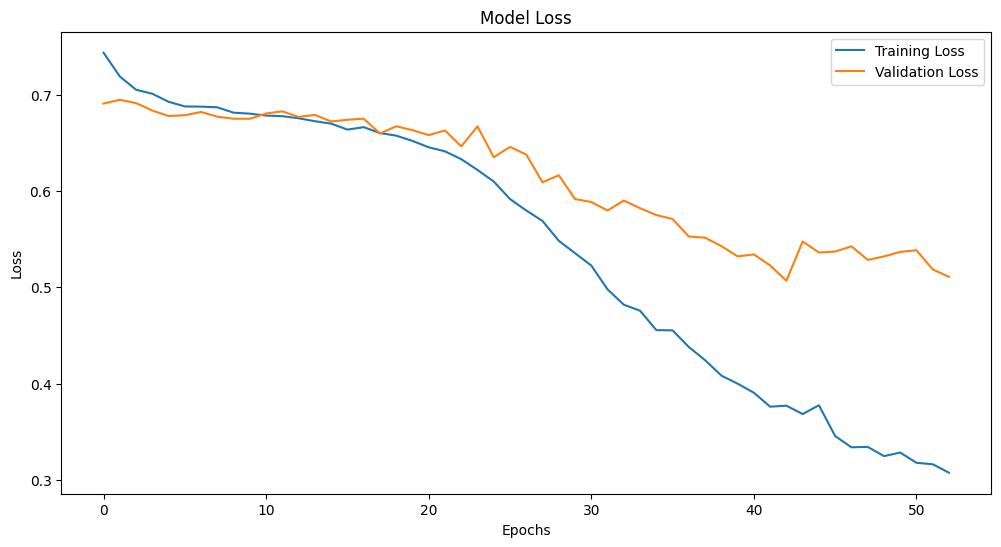

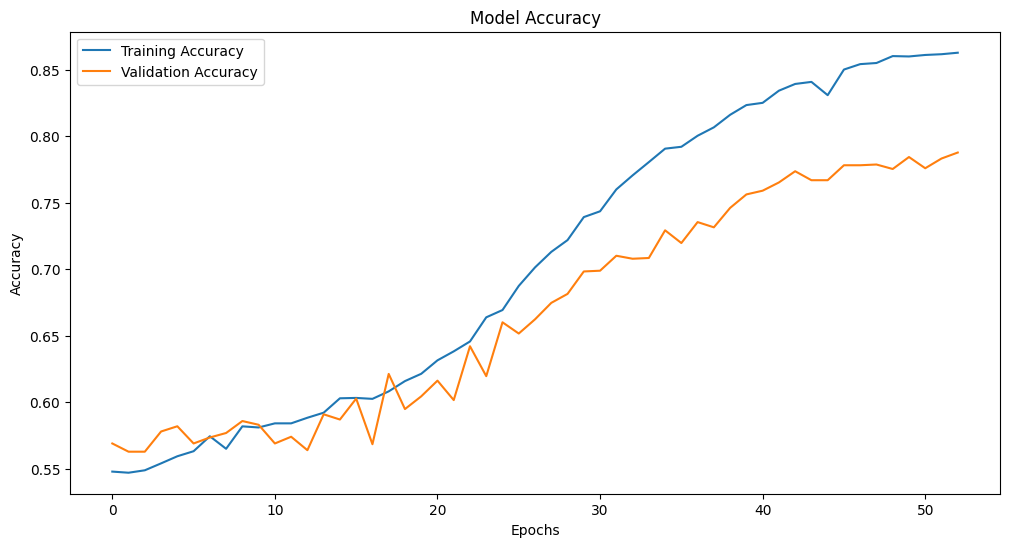

In [5]:
# training the model
# class_weights = {0: 1.5, 
#                  1: 1} 
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1000, batch_size = 32, callbacks=[early_stopping])

# Plotting the loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# Plotting the accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

## testing

In [6]:
X_test = snp500_test.drop(columns=['Direction'])
Y_test = snp500_test['Direction']

X_test = scaler.transform(X_test)
X_test_pca = pca.transform(X_test)

tempX, tempY = create_dataset(X_test_pca, Y_test, look_back)

Y_pred = model.predict(tempX)
Y_pred_labels = (Y_pred > 0.5).astype(int)

cm = confusion_matrix(tempY, Y_pred_labels)
print(cm)

print(classification_report(tempY, Y_pred_labels))

/var/folders/yb/gzz3qfxx7sn6c9801nm9qp9h0000gn/T/ipykernel_5106/2543105433.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y.append(y[i])


3/3 [==============================] - 1s 8ms/step
[[19 26]
 [14 32]]
              precision    recall  f1-score   support

           0       0.58      0.42      0.49        45
           1       0.55      0.70      0.62        46

    accuracy                           0.56        91
   macro avg       0.56      0.56      0.55        91
weighted avg       0.56      0.56      0.55        91



In [7]:
# reference
# https://github.com/arogan178/lstm-stock-prediction-sp500/blob/master/LSTM-price-prediction-sp500.ipynb